# Import Library


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Euclidean distance function

In [2]:
def compute_euclidean_distance_matrix(locations):
    """
    Compute Euclidean distance matrix for a list of locations.
    Args:
        locations: numpy array or list of shape (N, 2), with [x, y] coordinates for each node (depot + customers)
    Returns:
        distance_matrix: numpy array of shape (N, N) where (i, j) is the distance between node i and j
    """
    locations = np.array(locations)
    diff = locations[:, np.newaxis, :] - locations[np.newaxis, :, :]
    distance_matrix = np.sqrt(np.sum(diff**2, axis=-1))
    return distance_matrix


# Example usage:
# Suppose depot at (0,0), customer1 at (2,3), customer2 at (3,1), customer3 at (5,5)
locations = [
    [0, 0],  # Depot
    [2, 3],  # Customer 1
    [3, 1],  # Customer 2
    [5, 5],  # Customer 3
]
dist_matrix = compute_euclidean_distance_matrix(locations)
print(dist_matrix)

[[0.         3.60555128 3.16227766 7.07106781]
 [3.60555128 0.         2.23606798 3.60555128]
 [3.16227766 2.23606798 0.         4.47213595]
 [7.07106781 3.60555128 4.47213595 0.        ]]


# Import Data

In [3]:
# Load CSV files
df_customers = pd.read_excel(
    r"C:\rl-meta-test\src\Source\Solomon datasets\c101.xlsx", sheet_name="customer"
)
df_dataInfo = pd.read_excel(
    r"C:\rl-meta-test\src\Source\Solomon datasets\c101.xlsx", sheet_name="vehicle"
)

# Data Preparation

Fully data

In [ ]:
# Extract coordinates (x, y) of customers (including depot) and convert to NumPy array
xycoord = df_customers.iloc[:, 1:3].to_numpy()
distance = compute_euclidean_distance_matrix(xycoord).round(2)  # Calculate distance
# distance = pd.read_csv(
#    r"C:\rl-meta-test\src\Source\solomon_data\solomon25_csv\distance_matrix\c101distanceMatrix.csv"
# ).to_numpy()


# Extract demand for each customer as NumPy array
demand = df_customers.iloc[:, 3].to_numpy()

# Extract 'ready time' (earliest time service can begin at each customer)
readyTime = df_customers.iloc[:, 4].to_numpy()

# Extract 'due date' (latest time service must begin at each customer)
dueDate = df_customers.iloc[:, 5].to_numpy()

# Extract service time required at each customer
serviceTime = df_customers.iloc[:, 6].to_numpy()

# Extract vehicle information (such as capacity, number of vehicles, etc.) from the first row of df_dataInfo
vehicle = df_dataInfo.iloc[0, :].to_numpy()

kwargs = {
    "distance": distance,
    "demand": demand,
    "readyTime": readyTime,
    "dueDate": dueDate,
    "serviceTime": serviceTime,
    "vehicle": vehicle,
}


slicing data

In [4]:
customer = 10

# Extract coordinates (x, y) of customers (including depot) and convert to NumPy array
xycoord = df_customers.iloc[:customer, 1:3].to_numpy()
distance = compute_euclidean_distance_matrix(xycoord)  # Calculate distance
# distance = pd.read_csv(
#    r"C:\rl-meta-test\src\Source\solomon_data\solomon25_csv\distance_matrix\c101distanceMatrix.csv"
# ).to_numpy()


# Extract demand for each customer as NumPy array
demand = df_customers.iloc[:customer, 3].to_numpy()

# Extract 'ready time' (earliest time service can begin at each customer)
readyTime = df_customers.iloc[:customer, 4].to_numpy()

# Extract 'due date' (latest time service must begin at each customer)
dueDate = df_customers.iloc[:customer, 5].to_numpy()

# Extract service time required at each customer
serviceTime = df_customers.iloc[:customer, 6].to_numpy()

# Extract vehicle information (such as capacity, number of vehicles, etc.) from the first row of df_dataInfo
vehicle = df_dataInfo.iloc[0, :].to_numpy()

kwargs = {
    "distance": distance,
    "demand": demand,
    "readyTime": readyTime,
    "dueDate": dueDate,
    "serviceTime": serviceTime,
    "vehicle": vehicle,
}


# Differential Evolutional Algorithm Parameters

In [5]:
dimensions = len(distance) - 1 + vehicle[0]
maxiters = 100
n_pop = 100
bounds = np.array([[0, 1]] * dimensions)
Mutation_rate = np.array([0.9, 0.5])
Crossover_rate = np.array([0.5, 0.1])

island = 2
migration_rate = 0.5

# Differential Evolutional Algorithm


In [6]:
def differential_evolution(
    objective_func,
    bounds,
    population_size=n_pop,
    max_generations=maxiters,
    Mutation_rate=Mutation_rate,
    Crossover_rate=Crossover_rate,
    island=island,
    migration_rate=migration_rate,
    **kwargs,
):
    global_solution = np.array([])
    
    for num_island in range(island):
        if num_island == 0:
            # Initialize population
            population = np.random.uniform(
                bounds[:, 0], bounds[:, 1], (population_size, len(bounds))
            )
        else:
            # Initialize population
            population = np.random.uniform(
                bounds[:, 0], bounds[:, 1], (population_size, len(bounds))
            )
            migration_cost = np.array([])
            for obj in range(len(population)):
                migration_cost = np.insert(
                    migration_cost,
                    len(migration_cost),
                    objective_func(population[obj], **kwargs),
                )

            idx_good_migration = migration_cost.argsort()
            idx_bad_migration = np.flip(idx_good_migration)[
                : int(population_size * migration_rate)
            ]

            population[idx_bad_migration] = migration_population

        Upperbound_Mutation = Mutation_rate[1]
        Lowerbound_Mutation = Mutation_rate[0]
        Upperbound_Crossover_rate = Crossover_rate[1]
        Lowerbound_Crossover_rate = Crossover_rate[0]
        F = Mutation_rate[0]
        CR = Crossover_rate[0]

        for generation in range(max_generations):
            # print(f'Iteration {generation}')
            current_cost = np.array([])
            F += (Upperbound_Mutation - Lowerbound_Mutation) / max_generations
            CR += (
                Upperbound_Crossover_rate - Lowerbound_Crossover_rate
            ) / max_generations
            for i in range(population_size):
                # Mutation
                indices = [idx for idx in range(population_size) if idx != i]
                a, b, c = population[np.random.choice(indices, 3, replace=False)]
                mutant = population[i] + F * (b - c)

                # Crossover
                crossover_prob = np.random.rand(len(bounds))
                trial = np.where(crossover_prob < CR, mutant, population[i])

                # Selection
                fitness_trial = objective_func(trial, **kwargs)
                fitness_current = objective_func(population[i], **kwargs)

                if fitness_trial < fitness_current:
                    population[i] = trial
                    current_cost = np.insert(
                        current_cost, len(current_cost), fitness_trial
                    )
                else:
                    current_cost = np.insert(
                        current_cost, len(current_cost), fitness_current
                    )

            idx_best_migration = current_cost.argsort()[
                : int(population_size * migration_rate)
            ]
            migration_population = population[idx_best_migration]
            

            best_index_plot = current_cost[np.argmin(current_cost)]
            global_solution = np.insert(
                global_solution, len(global_solution), best_index_plot
            )

        # Find the best solution
        best_index = np.argmin(
            [objective_func(individual, **kwargs) for individual in population]
        )
        best_solution = population[best_index]

    return best_solution, global_solution

# Decoding

For experimental

In [7]:
def objective_func(x, **kwargs):
    vehicle = kwargs["vehicle"]
    seq = x[: -vehicle[0]].argsort() + 1
    sort = x[-vehicle[0] :].argsort()
    j = f_per_particle(
        seq, sort, **kwargs
    )  # [f_per_particle1(x[i], sort[i], i, **kwargs) if i <= 2 else f_per_particle(x[i], sort[i], **kwargs) for i in range(n_particles)]        # Calculate each particle.
    return np.array(j)


def f_per_particle(m, s, **kwargs):
    X = m  # Sequence
    V = s  # Vehicle
    obj_val = preserving_strategy(X, V, **kwargs)  # Call Preserving strategy.
    return obj_val

def preserving_strategy(X, V, **kwargs):
    # --- Unpack input data from keyword arguments ---
    dist = kwargs["distance"]  # Distance/time matrix between all nodes
    weight = kwargs["demand"]  # Demand (weight) for each customer node
    ready = kwargs["readyTime"]  # Ready time (earliest service time) for each node
    due = kwargs["dueDate"]  # Due time (latest service time) for each node
    service = kwargs["serviceTime"]  # Service time at each node
    vehicle = kwargs[
        "vehicle"
    ]  # Vehicle info: [number of vehicles, capacity per vehicle]
    # Get per-vehicle capacities (by indexing with V)
    pre_w_cap = np.array([vehicle[1]] * vehicle[0])
    w_cap = pre_w_cap[V]

    # -- Initialization --
    sequence = X  # Route sequence (includes depot at start & end)
    n_cust = len(sequence) - 2  # Number of customers (not counting depot nodes)
    n_veh = vehicle[0] - 1  # Number of vehicles - 1 (for indexing)
    i, k = 0, 0  # i: current position in sequence, k: vehicle index
    total_distance = 0  # Store total traveled distance (with penalty if any)

    # -- Main loop over each vehicle route --
    while k <= n_veh and i <= n_cust:
        # Initialize per-route accumulators
        route_dist, route_time, weight_load, penaltyCost = 0, 0, 0, 0

        if k > 0:
            i += 1  # Move to the next start customer for the next vehicle
        # Start route: depot to first customer
        route_dist += dist[0][sequence[i]]  # Distance depot -> first customer
        route_time += (
            service[0] + dist[0][sequence[i]]
        )  # Service + travel time to first customer
        weight_load += weight[sequence[i]]  # Initial cargo: first customer demand

        if route_time < ready[sequence[i]]:
            route_time = ready[sequence[i]]  # Wait if vehicle arrives before ready time

        if route_time > due[sequence[i]] or weight_load > w_cap[k]:
            penaltyCost += 1e11  # Penalty: arrived after due time (infeasible)
            break

        # --- Continue visiting customers along this route ---
        while i <= n_cust:
            route_dist += dist[sequence[i]][sequence[i + 1]]  # Add next leg distance
            route_time += (
                service[sequence[i]] + dist[sequence[i]][sequence[i + 1]]
            )  # Add service + travel time
            weight_load += weight[sequence[i + 1]]  # Add new customer demand

            if route_time < ready[sequence[i + 1]]:
                route_time = ready[sequence[i + 1]]  # Wait if arrive early at next node

            # If time window or capacity violated, backtrack and finish route
            if route_time > due[sequence[i + 1]] or weight_load > w_cap[k]:
                route_dist -= dist[sequence[i]][sequence[i + 1]]
                route_time -= service[sequence[i]] + dist[sequence[i]][sequence[i + 1]]
                weight_load -= weight[sequence[i + 1]]
                break
            i += 1

        # --- Finish by returning to depot ---
        route_dist += dist[sequence[i]][0]  # Add distance to depot
        route_time += (
            service[sequence[i]] + dist[sequence[i]][0]
        )  # Add service at last node + travel to depot
        if route_time > due[0]:
            penaltyCost += 1e11  # Penalty: returned to depot too late
        # Accumulate this route's total (distance + penalty if any)
        total_distance += route_dist + penaltyCost
        k += 1  # Next vehicle

    return (
        total_distance  # Return overall objective (distance with penalty if violated)
    )


For testing

In [ ]:
demand.sum()

In [ ]:
def objective_func(x, **kwargs):
    vehicle = kwargs["vehicle"]
    seq = x[: -vehicle[0]].argsort() + 1
    sort = x[-vehicle[0] :].argsort()
    j = f_per_particle(
        seq, sort, **kwargs
    )  # [f_per_particle1(x[i], sort[i], i, **kwargs) if i <= 2 else f_per_particle(x[i], sort[i], **kwargs) for i in range(n_particles)]        # Calculate each particle.
    return np.array(j)


def f_per_particle(m, s, **kwargs):
    X = m  # Sequence
    V = s  # Vehicle
    obj_val = preserving_strategy(X, V, **kwargs)  # Call Preserving strategy.
    return obj_val

def preserving_strategy(X, V, **kwargs):
    # --- Unpack input data from keyword arguments ---
    dist = kwargs["distance"]  # Distance/time matrix between all nodes
    weight = kwargs["demand"]  # Demand (weight) for each customer node
    ready = kwargs["readyTime"]  # Ready time (earliest service time) for each node
    due = kwargs["dueDate"]  # Due time (latest service time) for each node
    service = kwargs["serviceTime"]  # Service time at each node
    vehicle = kwargs[
        "vehicle"
    ]  # Vehicle info: [number of vehicles, capacity per vehicle]
    # Get per-vehicle capacities (by indexing with V)
    pre_w_cap = np.array([vehicle[1]] * vehicle[0])
    w_cap = pre_w_cap[V]

    # -- Initialization --
    sequence = X  # Route sequence (includes depot at start & end)
    n_cust = len(sequence) - 2  # Number of customers (not counting depot nodes)
    n_veh = vehicle[0] - 1  # Number of vehicles - 1 (for indexing)
    i, k = 0, 0  # i: current position in sequence, k: vehicle index
    total_distance = 0  # Store total traveled distance (with penalty if any)

    # -- Main loop over each vehicle route --
    while k <= n_veh and i <= n_cust:
        # Initialize per-route accumulators
        route_dist, route_time, weight_load, penaltyCost = 0, 0, 0, 0

        if k > 0:
            i += 1  # Move to the next start customer for the next vehicle
        # Start route: depot to first customer
        route_dist += dist[0][sequence[i]]  # Distance depot -> first customer
        route_time += (
            service[0] + dist[0][sequence[i]]
        )  # Service + travel time to first customer
        weight_load += weight[sequence[i]]  # Initial cargo: first customer demand

        if route_time < ready[sequence[i]]:
            route_time = ready[sequence[i]]  # Wait if vehicle arrives before ready time

        if route_time > due[sequence[i]] or weight_load > 75:
            penaltyCost += 1e11  # Penalty: arrived after due time (infeasible)
            break

        # --- Continue visiting customers along this route ---
        while i <= n_cust:
            route_dist += dist[sequence[i]][sequence[i + 1]]  # Add next leg distance
            route_time += (
                service[sequence[i]] + dist[sequence[i]][sequence[i + 1]]
            )  # Add service + travel time
            weight_load += weight[sequence[i + 1]]  # Add new customer demand

            if route_time < ready[sequence[i + 1]]:
                route_time = ready[sequence[i + 1]]  # Wait if arrive early at next node

            # If time window or capacity violated, backtrack and finish route
            if route_time > due[sequence[i + 1]] or weight_load > 75:
                route_dist -= dist[sequence[i]][sequence[i + 1]]
                route_time -= service[sequence[i]] + dist[sequence[i]][sequence[i + 1]]
                weight_load -= weight[sequence[i + 1]]
                break
            i += 1

        # --- Finish by returning to depot ---
        route_dist += dist[sequence[i]][0]  # Add distance to depot
        route_time += (
            service[sequence[i]] + dist[sequence[i]][0]
        )  # Add service at last node + travel to depot
        if route_time > due[0]:
            penaltyCost += 1e11  # Penalty: returned to depot too late
        # Accumulate this route's total (distance + penalty if any)
        total_distance += route_dist + penaltyCost
        k += 1  # Next vehicle

    return (
        total_distance  # Return overall objective (distance with penalty if violated)
    )


# Checking Solution

In [13]:
X = seq
V = sort

- [x] Calculate distance
- [x] Calculate weight
- [ ] calculate time Note: please rechecking index of sequence again

In [14]:
# --- Unpack input data from keyword arguments ---
dist = kwargs["distance"]  # Distance/time matrix between all nodes
weight = kwargs["demand"]  # Demand (weight) for each customer node
ready = kwargs["readyTime"]  # Ready time (earliest service time) for each node
due = kwargs["dueDate"]  # Due time (latest service time) for each node
service = kwargs["serviceTime"]  # Service time at each node
vehicle = kwargs[
    "vehicle"
]  # Vehicle info: [number of vehicles, capacity per vehicle]
# Get per-vehicle capacities (by indexing with V)
pre_w_cap = np.array([vehicle[1]] * vehicle[0])
w_cap = pre_w_cap[V]

# -- Initialization --
sequence = X  # Route sequence (includes depot at start & end)
n_cust = len(sequence) - 2  # Number of customers (not counting depot nodes)
n_veh = vehicle[0] - 1  # Number of vehicles - 1 (for indexing)
i, k = 0, 0  # i: current position in sequence, k: vehicle index
total_distance = 0  # Store total traveled distance (with penalty if any)

correct_solution = np.array([], dtype=int)

# -- Main loop over each vehicle route --
while k <= n_veh and i <= n_cust:
    # Initialize per-route accumulators
    route_dist, route_time, weight_load, penaltyCost = 0, 0, 0, 0

    if k > 0:
        i += 1  # Move to the next start customer for the next vehicle
    # Start route: depot to first customer
    route_dist += dist[0][sequence[i]]  # Distance depot -> first customer
    route_time += (
        service[0] + dist[0][sequence[i]]
    )  # Service + travel time to first customer
    weight_load += weight[sequence[i]]  # Initial cargo: first customer demand
    
    ### ADD
    correct_solution = np.insert(correct_solution, len(correct_solution), 0)
    ###
    
    if route_time < ready[sequence[i]]:
        route_time = ready[sequence[i]]  # Wait if vehicle arrives before ready time

    if route_time > due[sequence[i]] or weight_load > w_cap[k]:
        penaltyCost += 1e11  # Penalty: arrived after due time (infeasible)
        break

    # --- Continue visiting customers along this route ---
    while i <= n_cust:
        ### ADD
        correct_solution = np.insert(correct_solution, len(correct_solution), sequence[i])
        ###
        
        route_dist += dist[sequence[i]][sequence[i + 1]]  # Add next leg distance
        route_time += (
            service[sequence[i]] + dist[sequence[i]][sequence[i + 1]]
        )  # Add service + travel time
        weight_load += weight[sequence[i + 1]]  # Add new customer demand
        
        if route_time < ready[sequence[i + 1]]:
            route_time = ready[sequence[i + 1]]  # Wait if arrive early at next node

        # If time window or capacity violated, backtrack and finish route
        if route_time > due[sequence[i + 1]] or weight_load > w_cap[k]:
            route_dist -= dist[sequence[i]][sequence[i + 1]]
            route_time -= service[sequence[i]] + dist[sequence[i]][sequence[i + 1]]
            weight_load -= weight[sequence[i + 1]]
            break
        i += 1

    # --- Finish by returning to depot ---
    route_dist += dist[sequence[i]][0]  # Add distance to depot
    route_time += (
        service[sequence[i]] + dist[sequence[i]][0]
    )  # Add service at last node + travel to depot
    if route_time > due[0]:
        penaltyCost += 1e11  # Penalty: returned to depot too late
    # Accumulate this route's total (distance + penalty if any)
    total_distance += route_dist + penaltyCost
    k += 1  # Next vehicle
    
correct_solution = np.insert(correct_solution, len(correct_solution), sequence[-1])    
correct_solution = np.insert(correct_solution, len(correct_solution), 0)

print(f'Total travling distance : {total_distance}')  # Return overall objective (distance with penalty if violated)
print(f'sequence of customer : {correct_solution}')

Total travling distance : 51.72040199790072
sequence of customer : [0 5 3 7 8 9 6 4 2 1 0]


In [15]:
seq

array([5, 3, 7, 8, 9, 6, 4, 2, 1])

In [16]:
route1 = np.array([0, 7, 8, 9, 6, 0])
route2 = np.array([0, 5, 3, 4, 2, 1, 0])

In [ ]:
check_total = 0
for i in range(len(correct_solution)-1):
    check_total += distance[correct_solution[i]][correct_solution[i+1]]
check_total

In [ ]:
total_distance

In [ ]:
check_total

In [ ]:
total_distance == check_total

In [ ]:
print(f'Weight loading of vehicle 1 : {demand[route1].sum()} Kg.')
print(f'Weight loading of vehicle 2 : {demand[route2].sum()} Kg.')

In [ ]:
check_total_time = 0
for i in range(len(route1)-1):
    check_total_time += service[route1[i]] + distance[route1[i]][route1[i+1]]
    print(f'Ready time : {readyTime[route1[i+1]]}')
    print(f'Current traveling time : {check_total_time} mins.')
    print(f'Duedate : {dueDate[route1[i+1]]}')
    print('*'*30)
    if check_total_time < readyTime[route1[i+1]]:
        check_total_time = readyTime[route1[i+1]]
    elif check_total_time > dueDate[route1[i+1]]:
        print('Error')
check_total_time

In [ ]:
check_total_time = 0
for i in range(len(route2)-1):
    check_total_time += service[route2[i]] + distance[route2[i]][route2[i+1]]
    print(f'Ready time : {readyTime[route2[i+1]]}')
    print(f'Current traveling time : {check_total_time} mins.')
    print(f'Duedate : {dueDate[route2[i+1]]}')
    print('*'*30)
    if check_total_time < readyTime[route2[i+1]]:
        check_total_time = readyTime[route2[i+1]]
    elif check_total_time > dueDate[route2[i+1]]:
        print('Error')
check_total_time

# Finding Solution


In [8]:
start_algorithm = time.time()
best_solution, global_solution_plot = differential_evolution(
    objective_func,
    bounds=bounds,
    population_size=n_pop,
    max_generations=maxiters,
    Mutation_rate=Mutation_rate,
    Crossover_rate=Crossover_rate,
    island=island,
    migration_rate=migration_rate,
    **kwargs,
)
End_algorithm = time.time()
run_algorithm = End_algorithm - start_algorithm

In [9]:
seq = best_solution[: -vehicle[0]].argsort() + 1
sort = best_solution[-vehicle[0] :].argsort()
print(f'Sequence : {seq}')
print(f'Vehicle  : {sort}')

Sequence : [5 3 7 8 9 6 4 2 1]
Vehicle  : [17 15 14  3  4  0  8 13 11  6 18 21 23  5 19 12  7 20  2 10 24 22  1  9
 16]


In [10]:
preserving_strategy(seq, sort, **kwargs)

np.float64(51.72040199790072)

# Plotting

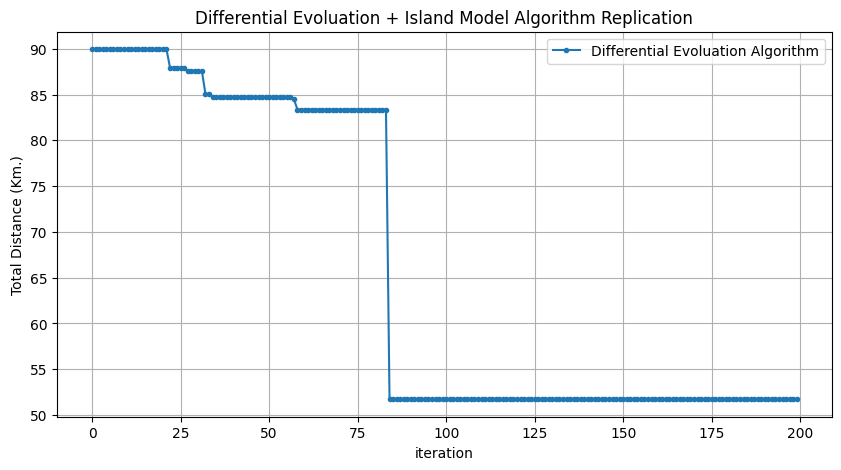

In [11]:
Replication = [i for i in range(len(global_solution_plot))]
y1 = global_solution_plot.tolist()
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(Replication, y1, marker=".", label="Differential Evoluation Algorithm")
ax.set(
    xlabel="iteration",
    ylabel="Total Distance (Km.)",
    title="Differential Evoluation + Island Model Algorithm Replication",
)
ax.grid()
ax.legend()
plt.show()

In [ ]:
y1[-1]